In [1]:
# Add parent directory
from sys import path as sysPath
sysPath.append('../')

# Add custom modules
sysPath.append('../Machine_Score/')

from Support_Code import general_module as gm
from Support_Code import info_module as im
from Image_Creator import main_image_creator as ic
from Machine_Score import main_machine_score as ms
from Machine_Score import direct_image_compare as dc
from Score_Analysis import main_score_analysis as sa
import main_SIMR as simr

# General modules
from os import path
import numpy as np
from matplotlib import pyplot as plt

sa.test()
gm.test()
im.test()
ic.test()
ms.test()
dc.test()
simr.test()

SA: Hi!  You're in Matthew's Main program for score analysis!
GM: Hi!  You're in Matthew's module for generally useful functions and classes
IM: Hi!  You're in Matthew Ogden's information module for SPAM
IC: Hi!  You're in Matthew's main code for all things image creation.
MS: Hi!  You're in Matthew's SIMR module for all things machine scoring images
DI: Hi!  You're in direct_image_compare.py
SIMR: Hi!  You're in Matthew's main program for all things galaxy collisions


In [2]:
#tDir = '/home/mbo2d/galStuff/spam_data_pl3/587722984435351614/' 
#tDir = '../../targetDir/'
tDir = '../../1237678620102623480/'

tInfo = im.target_info_class( targetDir = tDir, printAll=True)

if tInfo.status == False:
    print("WARNING")
else:
    print("Target Good!")

IM: target_info_class.__init__:
	 - targetDir:  ../../1237678620102623480/
IM: Target.initTargetDir():
	 - targetDir: ../../1237678620102623480/
NEW PATH EXISTS: /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/
	 - targetDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/
	 - infoDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/information/
	 - baseInfoLoc: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/information/base_target_info.json
	 - allInfoLoc: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/information/target_info.json
	 - zooMergerDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/
	 - plotDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/plots/
IM: Target: Opening target info json
Target Good!


In [3]:

print(tInfo.get('zoo_merger_models').get('00001'))

rId = 'r00001'
runArg = gm.inArgClass()
runArg.setArg("printAll",True)
runArg.setArg("tInfo",tInfo)

rInfo = tInfo.getRunInfo( rID=rId, rArg = runArg)
rInfo.tInfo = tInfo

if rInfo.status == False:
    print("WARNING")
else:
    print("Run '%s' Good!"%rInfo.get('run_id'))
    print(rInfo.get('tInfo').status)

None
IM: run_info_class.__init__
	 - runDir:  /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/
IM: run.initRunDir
	 - runDir: /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/
	 - runDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/
	 - ptsDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/particle_files/
	 - imgDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/model_images/
	 - miscDir: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/misc_images/
	 - infoLoc: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/info.json
	 - baseLoc: (True) /mnt/c/Users/ogden/OneDrive/Desktop/galStuff/1237678620102623480/zoo_merger_models/run_00001/base_i

In [7]:
# If you need to create a brand new json score parameter
tmp = '''
from copy import deepcopy
pLoc = gm.validPath('../param/start_param.json')
print(pLoc,'\n')
oldParams = im.group_score_parameter_class(pLoc = pLoc)
params = oldParams.group
gm.pprint(params)

params['new_score'] = deepcopy( params['base_score'] )
params['new_score']['name'] = 'test_compare'
params['new_score']['cmpArg']['cmpMethod'] = 'test_compare'

params['new_perturbation'] = deepcopy( params['new_score'] )
params['new_perturbation']['name'] = 'test_perturbation'
params['new_perturbation']['scoreType'] = 'perturbation'
params['new_perturbation'].pop('targetName',None)

params.pop('base_score',None)
params.pop('base_perturbation',None)

gm.pprint(params)

newParams = im.group_score_parameter_class( params = params )
newParams.saveParam( saveLoc = '../param/new_score.json')
'''

In [22]:
pLoc = gm.validPath('../param/new_score.json')
print(pLoc,'\n')
newParam = im.group_score_parameter_class(pLoc = pLoc)
if newParam.status == True:
    new_params = newParam.group
    print("New Score Params Good!")
    gm.pprint(params)
else:
    print("Failed to load new params")

/mnt/c/Users/ogden/OneDrive/Desktop/galStuff/galaxyJSPAM/param/new_score.json 

New Score Params Good!
{'new_perturbation': {'cmpArg': {'cmpMethod': 'test_compare'},
                      'imgArg': {'name': 'default',
                                 'pType': 'default'},
                      'name': 'test_perturbation',
                      'scoreType': 'perturbation',
                      'simArg': {'nPts': '100k',
                                 'name': '100k'}},
 'new_score': {'cmpArg': {'cmpMethod': 'test_compare'},
               'imgArg': {'name': 'default',
                          'pType': 'default'},
               'name': 'test_compare',
               'scoreType': 'target',
               'simArg': {'nPts': '100k',
                          'name': '100k'},
               'targetName': 'zoo'}}


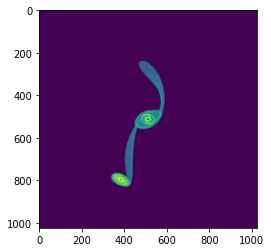

In [15]:
img1 = rInfo.getModelImg( params['new_score']['imgArg']['name'] )
plt.imshow(img1)

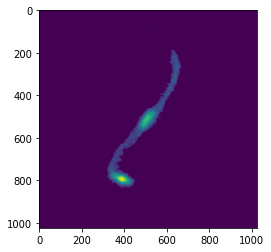

In [17]:
img2 = tInfo.getTargetImage( params['new_score']['targetName'] )
plt.imshow(img2)

In [18]:
from skimage.metrics import structural_similarity as ssim

def new_image_compare( img1, img2 ):
    score = 0
    score = ssim( img1, img2 )
    return score

score = new_image_compare( img1, img2 )
print(score)

0.9488813198644631


In [20]:
print(dc.test_compare)

dc.set_test_compare(new_image_compare)

print(dc.test_compare)

<function new_image_compare at 0x7fb14019f3a0>
<function new_image_compare at 0x7fb14019f3a0>


In [23]:
newRunScoreArg = gm.inArgClass()
newRunScoreArg.setArg( 'rInfo', rInfo )
newRunScoreArg.setArg( 'scoreParams', new_params )
newRunScoreArg.setArg( 'printAll', True )
newRunScoreArg.setArg( 'newScore', True )

simr.simr_run( rInfo = rInfo, arg = newRunScoreArg )


SIMR.pipelineRun: Inputs
	 - rDir: None
	 - rInfo: <class 'Support_Code.info_module.run_info_class'>
SIMR.pipelineRun: 
	 - rInfo:  <Support_Code.info_module.run_info_class object at 0x7fb1985b92b0>
MS: Run:
MS: target_image_compare: test_compare
	 -  paramName: test_compare
	 -  modelName: default
	 - targetName: zoo
	 - Read target image
MS: run: Read model image
IM: Run.saveInfoFile: Saving info data file...
IM: Run.saveInfoFile: Saving info data file...
Score Type of 'perturbation' not yet implemented
